### Visualization of our EEG data 
A notebook with different methods to visualize our data and results of classification  
Author: Shateesh Bhugwansing

## NOTE (10/31): 
The sensor spacing is off. I need to figure out why.
things to try (for next week):
- plotting 2D position data

In [1]:
# %run ../preprocessing/StimCodes.ipynb
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

In [2]:
# read in data 
epoch_path = '/Volumes/SB/EpochedEEG/20131216_1441_epo.fif'
epoch = mne.read_epochs(epoch_path, preload=True)

Reading /Volumes/SB/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [3]:
path = '/Users/shateeshbhugwansing/Desktop/seniorprojecteeg/Visualization/'
montage = mne.channels.read_montage(kind="ANT_DukeWaveGuard_128_electrode_montage_copy", ch_names=None, path=path, unit='mm', transform=False)

In [4]:
montage

<Montage | ANT_DukeWaveGuard_128_electrode_montage_copy - 127 channels: LE1, Nz, LE3 ...>

In [5]:
epoch.set_montage(montage)

The following EEG sensors did not have a position specified in the selected montage: ['Lm', 'Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.


<ipython-input-5-2b9523d69e31>:1: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['Lm', 'Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.
  epoch.set_montage(montage)


<EpochsFIF  |   5424 events (all good), -0.199219 - 0.5 sec, baseline [-0.199219, 0], ~961.2 MB, data loaded,
 'congruent': 320
 'correct': 231
 'f_baby': 68
 'f_bell': 48
 'f_bird': 48
 'f_burp': 28
 'f_dog': 64
 'f_drum': 60
 'f_knock': 56
 'f_laugh': 96
 'f_phone': 84
 'f_train': 56
 'f_water': 32
 'flanker_stim_1': 100
 'flanker_stim_10': 80
 'flanker_stim_11': 80
 'flanker_stim_12': 60
 'flanker_stim_2': 100
 'flanker_stim_3': 100
 'flanker_stim_4': 61
 'flanker_stim_5': 60
 'flanker_stim_6': 60
 'flanker_stim_7': 100
 'flanker_stim_8': 100
 'flanker_stim_9': 120
 'incongruent': 320
 'incorrect': 37
 'left_button': 334
 'right_button': 342
 't_baby': 60
 't_bell': 50
 't_bird': 50
 't_burp': 60
 't_dog': 60
 't_drum': 50
 't_knock': 60
 't_laugh': 70
 't_phone': 60
 't_train': 70
 't_water': 50
 'target_stim_13': 59
 'target_stim_14': 60
 'target_stim_15': 100
 'target_stim_16': 80
 'target_stim_17': 80
 'target_stim_18': 80
 'target_stim_19': 100
 'target_stim_20': 100
 'target_s

/Users/shateeshbhugwansing/anaconda/envs/mne/lib/python3.6/site-packages/mne/transforms.py:690: RuntimeWarning: invalid value encountered in true_divide
  out[:, 2] = np.arccos(cart[:, 2] / out[:, 0])


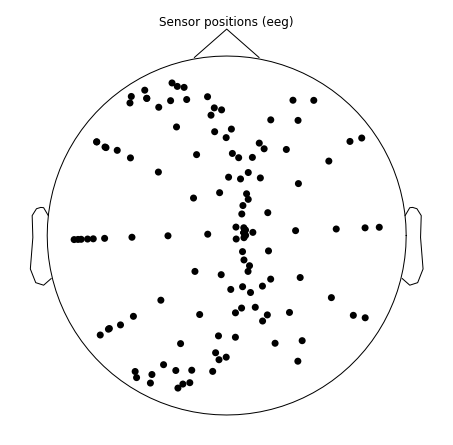

In [6]:
epoch.plot_sensors();

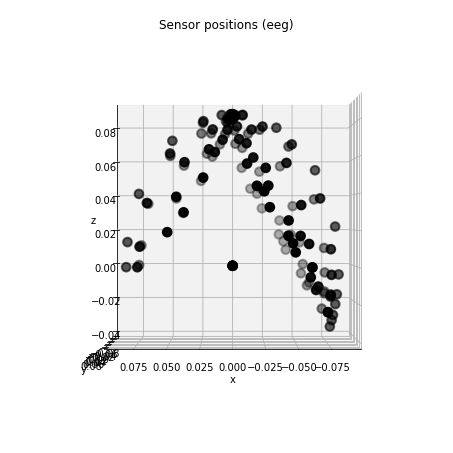

In [7]:
epoch.plot_sensors('3d');

In [23]:
## testing what the other montage file looks like (the example that Dave sent)

In [9]:
montage2 = mne.channels.read_montage(kind="eetrak124.elc", ch_names=None, path=path, unit='mm', transform=False)

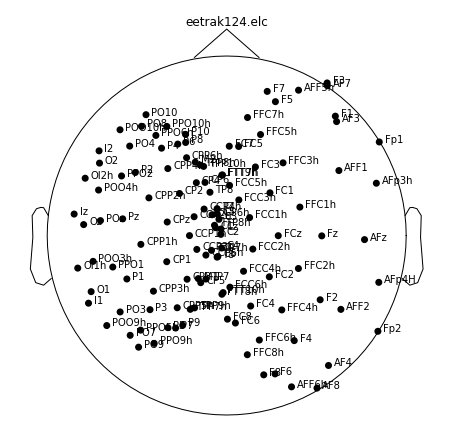

In [10]:
montage2.plot();

In [11]:
## testing MNE, built in montage
montage3 = mne.channels.read_montage('standard_1020')


4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 93 unique labels.


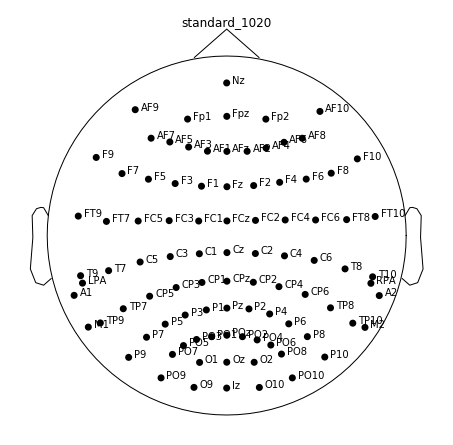

In [12]:
montage3.plot();

3 duplicate electrode labels found:
Nz/Veog, RR1/RR10, RA5/RA5
Plotting 124 unique labels.
Channel names are not unique, found duplicates for: {'RR1'}. Applying running numbers for duplicates.
The following EEG sensors did not have a position specified in the selected montage: ['RR1-1']. Their position has been left untouched.


<ipython-input-34-9b1703480041>:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'RR1'}. Applying running numbers for duplicates.
  montage.plot();
<ipython-input-34-9b1703480041>:1: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['RR1-1']. Their position has been left untouched.
  montage.plot();
/Users/shateeshbhugwansing/anaconda/envs/mne/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


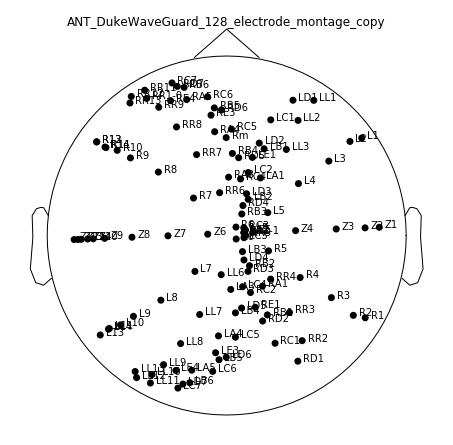

In [34]:
montage.plot();

## Sanity Check:
What does the montage look like as a normal scatter plot?

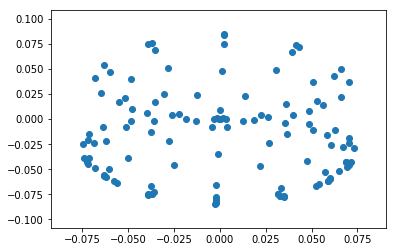

In [33]:
plt.scatter(montage.pos[:,1], montage.pos[:,0])

In [42]:
# try: manually editing the montage file columns so that the x axis is the first column, y axis is second
montage_rotated = mne.channels.read_montage(kind="ANT_DukeWaveGuard_128_electrode_montage_rotated", ch_names=None, path=path, unit='mm', transform=False)

3 duplicate electrode labels found:
Nz/Veog, RR1/RR10, RA5/RA5
Plotting 124 unique labels.
Channel names are not unique, found duplicates for: {'RR1'}. Applying running numbers for duplicates.
The following EEG sensors did not have a position specified in the selected montage: ['RR1-1']. Their position has been left untouched.


<ipython-input-43-6592fdd959ca>:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'RR1'}. Applying running numbers for duplicates.
  montage_rotated.plot();
<ipython-input-43-6592fdd959ca>:1: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['RR1-1']. Their position has been left untouched.
  montage_rotated.plot();
/Users/shateeshbhugwansing/anaconda/envs/mne/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


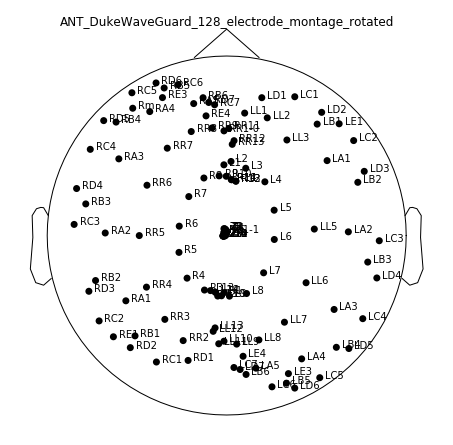

In [43]:
montage_rotated.plot();

### THEN WHY THE HECK IS IT ROTATED USING MONTAGE.PLOT??

## Mapping coefficients to the channels
Map the coefficients of Logistic Regression to the channels of the ANT Waveguard Duke cap

In [13]:
# %run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
# %run ../preprocessing/StimCodes.ipynb
# %run ../Classification/ConcatEpochTrails.ipynb
# %run ../PCA/Emmanuil-PCA.ipynb

from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

import time

In [14]:
new_stim_code_event_ids = {
     
    "b-f2-wrd":1,
    "b-f1-wrd":2,
    "b-tg-wrd":3,

    "b-f2-spk":4,
    "b-f1-spk":5,
    "b-tg-spk":6,

    "b-f2-pic":7,
    "b-f1-pic":8,
    "b-tg-pic":9,

    "b-f2-snd":10,
    "b-f1-snd":11,
    "b-tg-snd":12,

    "f-f2-wrd":13,
    "f-f1-wrd":14,
    "f-tg-wrd":15,

    "f-f2-spk":16,
    "f-f1-spk":17,
    "f-tg-spk":18,

    "f-f2-pic":19,
    "f-f1-pic":20,
    "f-tg-pic":21,

    "f-f2-snd":22,
    "f-f1-snd":23,
    "f-tg-snd":24
}

In [15]:
## the following is from Emmanuil's Audio vs. Visual notebook

In [ ]:
# get indicies of trials of epoch object
trial_index_list = get_trial_index_list(epoch_object= epoch)

In [ ]:
# get new events for epoch object
new_event_list = convert_event_ids_to_stim_combinations(epoch_object=epoch,
                                                        trial_index_list = trial_index_list,
                                                        stim_combinations = stim_combinations)

In [ ]:
print(epoch.events.shape)
print(new_event_list.shape)

In [ ]:
# assign new events to current epoch object
epoch.events = new_event_list

# assign new event_ids to current epoch object (dictionary 
# found in ../Classification/ConcatEpochTrails.ipynb)
 
epoch.event_id = modality_lexicality_event_ids

In [ ]:
# classification time!

# Isolate audio vs visual codes
# audio codes are < 700, # visual codes are > 700 
# audio : 100 , visual : 101
for event in epoch.events:
    if event[-1] < 700:
        event[-1] = 100
    else:
        event[-1] = 101

In [ ]:
norm_pipe = make_pipeline(Vectorizer(), 
                          StandardScaler())
norm_pipe.fit(epoch.get_data())

In [ ]:
scaled_data = norm_pipe.transform(epoch.get_data())
scaled_data.shape

In [ ]:
# do PCA to reduce dimensions and data needed for classification.
# pca = UnsupervisedSpatialFilter(PCA(28), average=False) # PCA, keep 9 components 

epoch_data = epoch.get_data()
# pca_data = pca.fit_transform(epoch_data)

In [ ]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = epoch.events[:,-1]
preds = np.empty(len(epoch_data))
for train, test in cv.split(epoch_data, labels):
    start = time.time()
    clf.fit(epoch_data[train], labels[train])
    preds[test] = clf.predict(epoch_data[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Audio', 'Visual']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

## Emmanuil's classification code crashed. 
## Going to use what Tarekul did.

In [17]:
def update_stim_code(epoch):
    keys_to_delete = [x for x in epoch.event_id if 'stim' in x]
    for key in keys_to_delete:
        if 'stim' in key:
            del epoch.event_id[key]
            
    for key in new_stim_code_event_ids:
        epoch.event_id[key] = new_stim_code_event_ids[key]
    
    return epoch

In [18]:
epochWnewStim = update_stim_code(epoch)
epochWnewStim.events.shape

(5424, 3)

In [19]:
events = epochWnewStim.events[:,-1]
event_ids = epochWnewStim.event_id

In [20]:
stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
    
    
    
}

In [21]:
events = epochWnewStim.events
events_new = []
temp = []
combo = []


for event in events:
    if event[-1] == 31:
        combo = []
        for trialEpochs in temp:
            if trialEpochs[-1] >=1 and trialEpochs[-1]<=24:
                combo.append(trialEpochs[-1])
        if len(combo) == 3: 
            combo_tuple = (combo[0],combo[1],combo[2]) 
            if stim_combinations[combo_tuple] == "VVNN" :
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 100
            elif stim_combinations[combo_tuple] == "AANN":
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 200       
            combo_tuple = []
                
        
        for p in temp:
            if p[-1] == 100 or p[-1] == 200:
                events_new.append(p)
#             if p[-1] >=1 and p[-1] <=24:
#                 events_new.append(p)
        temp = []
        temp.append(event)
    else:
        temp.append(event)
events_new

[array([27806,     0,   100]),
 array([27931,     0,   100]),
 array([28060,     0,   100]),
 array([28521,     0,   100]),
 array([28646,     0,   100]),
 array([28775,     0,   100]),
 array([29292,     0,   100]),
 array([29417,     0,   100]),
 array([29546,     0,   100]),
 array([29826,     0,   100]),
 array([29951,     0,   100]),
 array([30080,     0,   100]),
 array([30752,     0,   100]),
 array([30876,     0,   100]),
 array([31006,     0,   100]),
 array([31406,     0,   100]),
 array([31531,     0,   100]),
 array([31660,     0,   100]),
 array([31940,     0,   100]),
 array([32065,     0,   100]),
 array([32194,     0,   100]),
 array([32646,     0,   100]),
 array([32771,     0,   100]),
 array([32900,     0,   100]),
 array([33383,     0,   100]),
 array([33508,     0,   100]),
 array([33637,     0,   100]),
 array([35463,     0,   100]),
 array([35587,     0,   100]),
 array([35717,     0,   100]),
 array([36328,     0,   100]),
 array([36453,     0,   100]),
 array([

In [22]:
#New epoch with only visual stim code combinations
test = epochWnewStim[(epochWnewStim.events[:,-1]==100) | (epochWnewStim.events[:,-1]==200)].copy()

In [23]:
from sklearn.cross_validation import train_test_split

#set features as epoch data
#set targets as event ids
features_data = test.get_data()
target_V_vs_A = test.events[:,-1]

print("shape of data",features_data.shape)
print("shape of target array",target_V_vs_A.shape)




shape of data (360, 129, 180)
shape of target array (360,)


/Users/shateeshbhugwansing/anaconda/envs/mne/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
#new epoch with only events corresponding to 100 or 200(visual/audio stim codes)
binaryEpoch = epochWnewStim[(epochWnewStim.events[:,-1]==100) | (epochWnewStim.events[:,-1]==200)].copy()

In [25]:
#pipeling for converting data from 3D to 2D using vectorizer and
#LogisticRegression for classification
clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    (LogisticRegression(C=1)))

#Provides train/test indices to split data in train/test sets.
cv = StratifiedKFold(n_splits = 10, shuffle=True)
#y_preds = np.empty(len(target_V_vs_A))
score = []
# tprs = []
# aucs = []
# mean_fpr = np.linspace(0, 1, 100)

#i = 0
for train,test in cv.split(features_data,target_V_vs_A):
    X_train = features_data[train] 
    #print("shape of training features(data):",X_train.shape)
    y_train = target_V_vs_A[train] 
    #print("shape of training target:",y_train.shape)
    X_test = features_data[test] 
    #print("shape of testing data:",X_test.shape)
    y_test = target_V_vs_A[test]
    #print("shape of testing target:",y_test.shape)
    
    #fit the model to training set
    clf.fit(X_train,y_train)
    
    #returns the mean accuracy on test data and labels
    score.append(clf.score(X_test,y_test))
    
    
    




In [26]:
print("mean classification score", np.mean(score))

mean classification score 0.775


In [27]:
from mne.decoding import get_coef
#get the coeficients after fitting clf to training sets
patterns2 = get_coef(clf,'coef_')
#print(patterns2)

#convert patterns2 to 129 x 180 array from 1 x 23220
#take each block of 180 coeficients and put them together 
#for each channel. We will have 129 channels rows with
#180 time columns
hold = []
for h in range(0,23219,180):
    temp = []
    for i in range(h,h+180):
        temp.append(patterns2[0][i])
    hold.append(temp)     
npHold = np.array(hold)
npHold.shape

(129, 180)

In [28]:
len(epoch.ch_names)

129

In [29]:
npHold_avg = []

for i in range(len(npHold)):
    npHold_avg.append(np.mean(npHold[i]))

# npHold_avg = np.array(npHold_avg)
print (len(npHold_avg))


129


In [30]:
channels = epoch.ch_names


In [31]:
channels_and_coeff = dict(zip(channels, npHold_avg))
channels_and_coeff

{'Lm': 0.0011437760810810882,
 'LE1': 0.001329902106040306,
 'Nasium': -0.0001541536086993062,
 'LE3': 0.0036939949985760477,
 'LD2': 0.0007136602511141087,
 'LD5': 0.002796741166808239,
 'LC3': 0.0008866818250475395,
 'LC6': -0.0011966999649559214,
 'LB1': 0.0015448792652226716,
 'LB4': -0.0007031567936982552,
 'LA2': -3.1171129453755716e-05,
 'LA5': -0.002987506332667802,
 'LL1': -0.0008768993930055109,
 'LL4': 0.0009035123314115846,
 'LL7': -0.001962493619621931,
 'LL10': -0.0028260286670864364,
 'LL13': 6.813668180054994e-05,
 'L3': -0.0021367071437547037,
 'L6': 0.0004020174228340387,
 'L9': -0.0023995232291611707,
 'L12': 0.002550756881585019,
 'Z1': -0.0008880984238201381,
 'Z4': -0.001831610141418318,
 'Z7': -0.0007045407968676597,
 'Z10': -0.0035303405698439605,
 'Z13': -0.0010750641030177486,
 'R3': -0.0016835966723651459,
 'R6': 0.0005403208229654555,
 'R9': -0.004539220153199923,
 'R12': 0.00031519206631038015,
 'RR1': -0.0012046980904558218,
 'RR4': -9.577379163115712e-05,

In [ ]:
# by observation, the averaged coefficients seem to be biggest on the scale of 0.001 

coeff_of_interest = {k:v for (k,v) in channels_and_coeff.items() if abs(v) > 0.001 }

In [ ]:
coeff_of_interest

In [44]:
# Taking the average didn't work. Trying a new approach
# Interpolation of 2d data. 
# reference: https://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/interpolate.html#using-radial-basis-functions-for-smoothing-interpolation

# set up x,y coordinates by taking the min, max of x,y coordinates of montage file. 
x_min = np.amin(montage.pos[:,1])
x_max = np.amax(montage.pos[:,1])
print ("x range: ", x_max, x_min)

y_min = np.amin(montage.pos[:,0])
y_max = np.amax(montage.pos[:,0])
print("y range: ", y_min, y_max)

x range:  0.07321516459737132 -0.07464377253137654
y range:  -0.08482596914318734 0.08496362450076278


In [100]:
xi = np.linspace(y_min, y_max)
yi = np.linspace(y_min, y_max)

In [72]:
type(xi)

numpy.ndarray

In [101]:
XI, YI = np.meshgrid(yi, yi)

In [102]:
np.array(XI).shape

(50, 50)

In [103]:
# Grid is set up. as for the data:
# x = x-axis location of sensor (montage.pos[1])
# y = y-axis location of sensor (montag.pos[0])
# z = coefficient used in linear regression

print( len(montage.pos[:,1]), len(montage.pos[:,0]), len(npHold_avg))

127 127 129


In [104]:
len(epoch.ch_names)

129

In [105]:
len(montage.ch_names)

127

#### NOTE: What I'm doing here is wrong. I should have filtered out the channels that are NOT the same in the epoch.ch_name and montage.ch_name

In [106]:
averaged_coefficients = npHold_avg[:-2]

In [107]:
len(averaged_coefficients)

127

In [108]:
print("Mine: ", type(x[0]), len(x), type(y[0]), len(y), type(z[0]), len(z))

Mine:  <class 'numpy.float64'> 124 <class 'numpy.float64'> 124 <class 'numpy.float64'> 124


In [119]:
type(npHold)

numpy.ndarray

In [109]:
# set up scattered data 
from scipy.interpolate import Rbf

x = montage.pos[:,1]
y = montage.pos[:,0]
z = np.array(averaged_coefficients)

In [110]:
# Have to remove the duplicate x,y coordinates in order to get Rbf to work
# NEED TO PRESERVE ORDER (can't sort them!!)

def unique_unsorted(arr):
    _, idx = np.unique(arr, return_index=True)
    
    return arr[np.sort(idx)], idx

In [111]:
x, x_idx = unique_unsorted(x)
y, y_idx  = unique_unsorted(y)

In [112]:
# Filter z to get rid of the same indicies that the x array got rid of. 
z = z[np.sort(y_idx)]
print(len(z))

124


In [113]:
type(x[0])

numpy.float64

In [114]:
rbf = Rbf(x,y,z, epsilon=2)

/Users/shateeshbhugwansing/anaconda/envs/mne/lib/python3.6/site-packages/scipy/interpolate/rbf.py:220: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.961231e-20
  self.nodes = linalg.solve(self.A, self.di)


In [115]:
ZI = rbf(XI, YI)

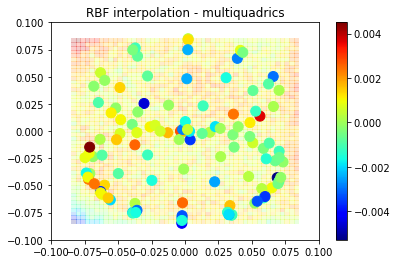

In [137]:
# plot the result
n = plt.Normalize(-2., 2.)
plt.subplot(1, 1, 1)
plt.pcolor(XI, YI, ZI, cmap=cm.jet, alpha=0.2)
plt.scatter(x, y, 100, z, cmap=cm.jet)
plt.title('RBF interpolation - multiquadrics')
plt.xlim(-.1, .1)
plt.ylim(-.1, .1)
plt.colorbar()

### try the same thing, with a different z-axis value. 
#### try z = npHold[0] ?

In [124]:
z2 = npHold[:,0]

In [126]:
z2 = z2[np.sort(y_idx)]


In [129]:
z2.shape

(124,)

In [130]:
rbf2 = Rbf(x,y,z2, epsilon=2)

/Users/shateeshbhugwansing/anaconda/envs/mne/lib/python3.6/site-packages/scipy/interpolate/rbf.py:220: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.961231e-20
  self.nodes = linalg.solve(self.A, self.di)


In [131]:
ZI2 = rbf2(XI, YI)

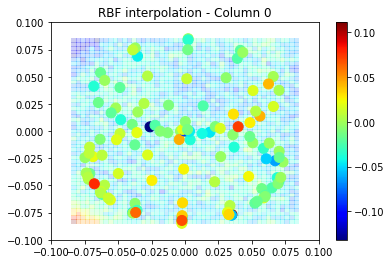

In [143]:
# plot the result
n = plt.Normalize(-2., 2.)
plt.subplot(1, 1, 1)
plt.pcolor(XI, YI, ZI2, cmap=cm.jet, alpha=0.2)
plt.scatter(x, y, 100, z2, cmap=cm.jet)
plt.title('RBF interpolation - Column 0')
plt.xlim(-.1, .1)
plt.ylim(-.1, .1)
plt.colorbar()

### Do this for a few other columns, to show change over time

In [139]:
z3 = npHold[:,30]
z4 = npHold[:,60]
z5 = npHold[:,120]

In [140]:
z3 = z3[np.sort(y_idx)]
z4 = z4[np.sort(y_idx)]
z5 = z5[np.sort(y_idx)]

In [141]:
rbf3 = Rbf(x,y,z3, epsilon=2)
rbf4 = Rbf(x,y,z4, epsilon=2)
rbf5 = Rbf(x,y,z5, epsilon=2)

/Users/shateeshbhugwansing/anaconda/envs/mne/lib/python3.6/site-packages/scipy/interpolate/rbf.py:220: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.961231e-20
  self.nodes = linalg.solve(self.A, self.di)


In [142]:
ZI3 = rbf3(XI, YI)
ZI4 = rbf4(XI, YI)
ZI5 = rbf5(XI, YI)

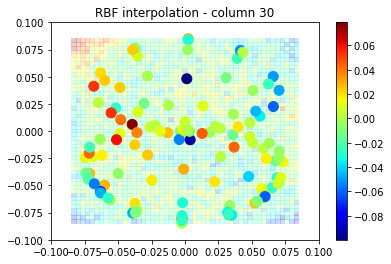

In [144]:
# plot the result
n = plt.Normalize(-2., 2.)
plt.subplot(1, 1, 1)
plt.pcolor(XI, YI, ZI3, cmap=cm.jet, alpha=0.2)
plt.scatter(x, y, 100, z3, cmap=cm.jet)
plt.title('RBF interpolation - column 30')
plt.xlim(-.1, .1)
plt.ylim(-.1, .1)
plt.colorbar()

In [ ]:
# plot the result
n = plt.Normalize(-2., 2.)
plt.subplot(1, 1, 1)
plt.pcolor(XI, YI, ZI3, cmap=cm.jet, alpha=0.2)
plt.scatter(x, y, 100, z3, cmap=cm.jet)
plt.title('RBF interpolation - column 30')
plt.xlim(-.1, .1)
plt.ylim(-.1, .1)
plt.colorbar()

### Topography Map

In [ ]:
projs = mne.compute_proj_epochs(epoch)

In [ ]:
epoch_projs = epoch.add_proj(projs)

In [ ]:
type(epoch_projs)

In [ ]:
type(epoch)

In [ ]:
epoch_projs.plot_projs_topomap()

In [ ]:
epoch.plot_projs_topomap()

### topomap() is not working. Maybe I need to manaully create a layout